In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = {} # (prot, grid) -> ligand ->  np.array(N, 2) (rmsds, gscores)
with open('../combind_sherlock/bpp_outputs/glide_performance_glide12.tsv') as fp:
    for line in fp:
        try:
            (protein, grid, ligand, rmsds, gscores, emodels,
             inplace_gscore, inplace_emodel, inplace_rmsd) = line.strip().split('\t')
            inplace_gscore = float(inplace_gscore)
            inplace_emodel = float(inplace_emodel)
            inplace_rmsd = float(inplace_rmsd)
            rmsds = map(float, rmsds.split(','))
            gscores = map(float, gscores.split(','))
            emodels = map(float, emodels.split(','))
            assert len(rmsds) == len(gscores)
            key = (protein, grid)
            if key not in data: data[key] = {}
            assert ligand not in data[key]
            data[key][ligand] = (np.vstack([rmsds, gscores, emodels]),
                                 inplace_gscore, inplace_emodel, inplace_rmsd)
        except:
            print line.strip().split()[:3]

['BRAF', '1UWH', '3TV4_lig']
['BRAF', '1UWH', '4MNF_lig']
['BRAF', '1UWH', '4R5Y_lig']
['BRAF', '1UWH', '4YHT_lig']
['BRAF', '1UWH', '5C9C_lig']
['BRAF', '1UWH', '5CSW_lig']
['BRAF', '1UWH', '5CT7_lig']
['BRAF', '1UWH', '5FD2_lig']
['ERA', '1A52', '1L2I_lig']


In [3]:
print len(data)
print sum([len(v) for k, v in data.items()])
for count, key in sorted([(len(v), k) for k, v in data.items()]):
    print count, key[0]

36
653
2 5HT2B
2 M3
2 SIGMA1
2 TRPV1
3 GLUT1
5 MGLUR5
5 STRANSP
7 SMO
8 B2AR
9 DTRANSP
11 AR
12 B1AR
12 PLK1
13 MR
13 P24941
14 P03951
17 O60885
18 A2AR
18 GCR
24 P00489
24 Q16539
24 Q9Y233
27 ERA
27 P00749
28 BRAF
28 CHK1
29 CDK2
29 MEK1
30 JAK2
30 P00734
30 P00742
30 P00760
30 P07900
30 P18031
30 P56817
30 VITD


# Percentage with minimized pose

In [4]:
inplace = [(g, rmsds[0].min())
           for (prot, grid), ligands in data.items()
           for ligand, (rmsds, g, e, r) in ligands.items()
           if ligand.split('_')[0] != grid]
inplace = np.array(inplace)
print inplace.shape
print sum(inplace[:, 0] != float('inf')) / float(len(inplace))

(619, 2)
0.833602584814


In [5]:
# What is going on in the 20 cases where we can't get a minimized pose?
print 'No inplace, no native', sum(inplace[inplace[:, 0] == float('inf'), 1] > 2)
print 'No inplace, native', sum(inplace[inplace[:, 0] == float('inf'), 1] <= 2)
print 'Inplace, no native', sum(inplace[inplace[:, 0] != float('inf'), 1] > 2)
print 'Inplace, native', sum(inplace[inplace[:, 0] != float('inf'), 1] <= 2)

No inplace, no native 89
No inplace, native 14
Inplace, no native 99
Inplace, native 417


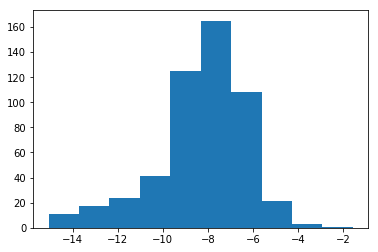

In [6]:
plt.hist(inplace[inplace[:, 0] != float('inf'), 0])
plt.show()

(array([  52.,   45.,   15.,   49.,   49.,   52.,   49.,   45.,   62.,  201.]),
 array([   1. ,   30.9,   60.8,   90.7,  120.6,  150.5,  180.4,  210.3,
         240.2,  270.1,  300. ]),
 <a list of 10 Patch objects>)

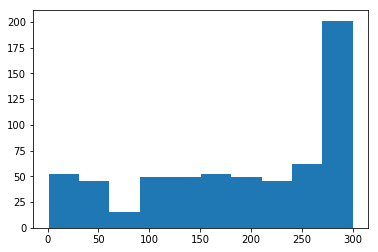

In [7]:
lengths = [rmsds.shape[1]
           for (prot, grid), ligands in data.items()
           for ligand, (rmsds, g, e, r) in ligands.items()
           if ligand.split('_')[0] != grid]
plt.hist(lengths)

# Glide performance for all ligands

In [8]:
def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

def performance(rmsds):
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]

    POSE = [0, 1, 3, 10, 30, 100, 300]
    THRESH = [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]

    for thresh in THRESH:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSE]
        plt.plot(Y, label = "< {} rmsd".format(thresh))
    plt.xticks(range(len(POSE)),POSE)
    plt.legend(loc = 4)
    plt.ylabel('Fraction Correct')
    plt.xlabel('Number of Poses Considered')
    plt.title('All Proteins')
    plt.ylim(0, 1)
    plt.xlim(0, len(POSE)-1)
    plt.show()

    # Table
    potential = Table([10]*4)
    potential(['RMSD', 'top 1', 'top 100', 'Potential'])

    for thresh in THRESH:
        potential([thresh,
                   percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 100, thresh), 
                   percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
                  ])

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


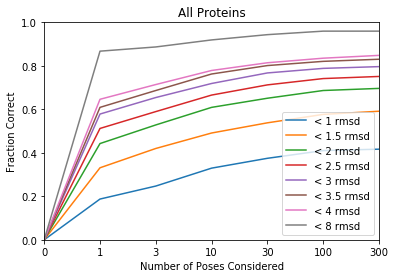

RMSD      top 1     top 100   Potential 
1         0.1873990 0.4103392 0.2229402 
1.5       0.3311793 0.5767366 0.2455573 
2         0.4426494 0.6865912 0.2439418 
2.5       0.5121163 0.7415185 0.2294022 
3         0.5783521 0.7883683 0.2100161 
3.5       0.6090468 0.8206785 0.2116316 
4         0.6462035 0.8352180 0.1890145 
8         0.8675282 0.9596122 0.0920840 


In [9]:
rmsds = [rmsds[[0, 1]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


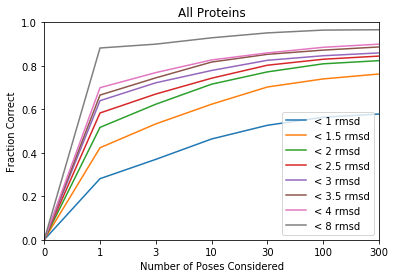

RMSD      top 1     top 100   Potential 
1         0.2810985 0.5638126 0.2827140 
1.5       0.4232633 0.7399030 0.3166397 
2         0.5169628 0.8093699 0.2924071 
2.5       0.5831987 0.8303715 0.2471728 
3         0.6397415 0.8465266 0.2067851 
3.5       0.6655896 0.8723747 0.2067851 
4         0.6995153 0.8852988 0.1857835 
8         0.8820678 0.9644588 0.0823909 


In [10]:
rmsds = [np.hstack([rmsds[[0, 1]], np.array([r, g]).reshape(2, 1)])
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


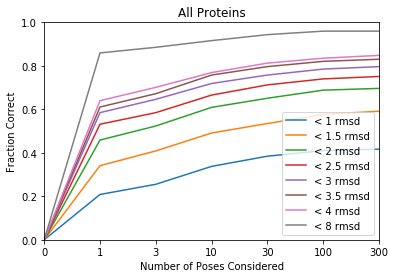

RMSD      top 1     top 100   Potential 
1         0.2084006 0.4103392 0.2019386 
1.5       0.3408723 0.5767366 0.2358642 
2         0.4588045 0.6882067 0.2294022 
2.5       0.5315024 0.7399030 0.2084006 
3         0.5848142 0.7851373 0.2003231 
3.5       0.6106623 0.8206785 0.2100161 
4         0.6397415 0.8352180 0.1954765 
8         0.8594507 0.9596122 0.1001615 


In [11]:
rmsds = [rmsds[[0, 2]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


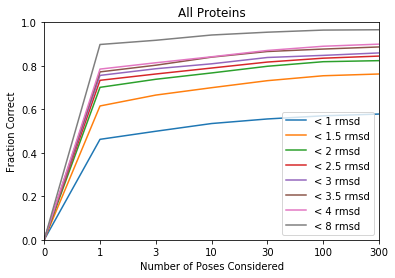

RMSD      top 1     top 100   Potential 
1         0.4620355 0.5702746 0.1082390 
1.5       0.6155088 0.7544426 0.1389337 
2         0.7011308 0.8190630 0.1179321 
2.5       0.7334410 0.8352180 0.1017770 
3         0.7560581 0.8481421 0.0920840 
3.5       0.7722132 0.8772213 0.1050080 
4         0.7851373 0.8901453 0.1050080 
8         0.8982229 0.9644588 0.0662358 


In [12]:
# Note: Emodel scores are comparable across docking runs, so this is not a fair comparison..
rmsds = [np.hstack([rmsds[[0, 2]], np.array([r, e]).reshape(2, 1)])
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

# Glide performance averaged over targets

In [13]:
def target_performance(top1, top100, labels):
    print 'Top pose is correct', sum(top1) / float(len(top1))
    print 'Top 100 has one correct', sum(top100) / float(len(top100))

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(top1, top100, labels)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Top 1', fontsize = 16)
    plt.ylabel('Top 100', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=2)
    plt.show()

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.438250131839
Top 100 has one correct 0.71820344966


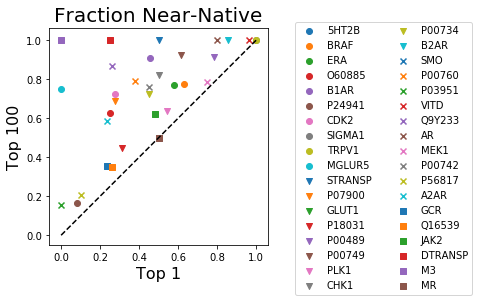

In [14]:
# GScore
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [rmsds[[0, 1]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.34028839726
Top 100 has one correct 0.589719844124


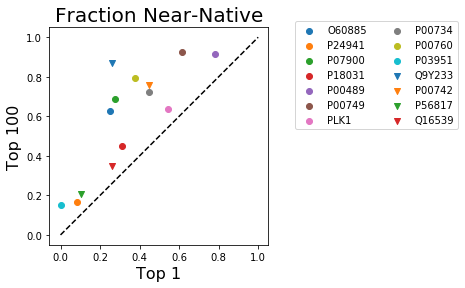

In [15]:
# GScore, only PDBbind
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    if prot[0] not in ['P', 'Q', 'O']: continue
    if prot == 'PLK': continue
    rmsds = [rmsds[[0, 1]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.489339136821
Top 100 has one correct 0.809078245137


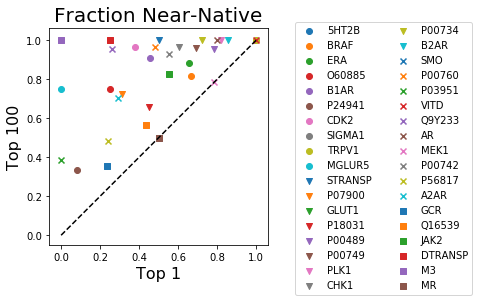

In [16]:
# GScore + in place
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [np.hstack([rmsds[[0, 1]], np.array([r, g]).reshape(2, 1)])
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.495431602194
Top 100 has one correct 0.720657750007


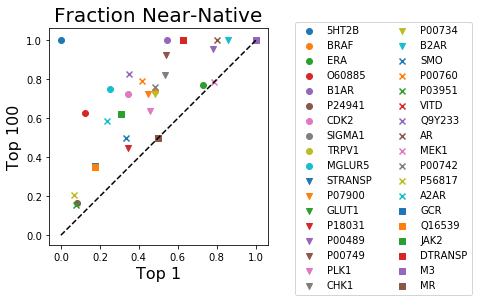

In [17]:
# Emodel
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [rmsds[[0, 2]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.344570752835
Top 100 has one correct 0.592182898311


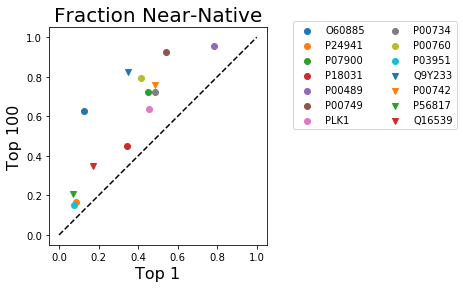

In [18]:
# Emodel, only PDBbind
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    if prot[0] not in ['P', 'Q', 'O']: continue
    if prot == 'PLK': continue
    rmsds = [rmsds[[0, 2]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.721765561425
Top 100 has one correct 0.819551423209


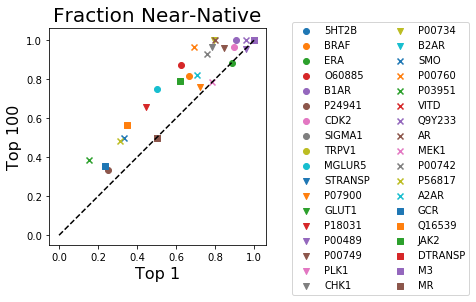

In [19]:
# Emodel + in place
# Note: Emodel scores are comparable across docking runs, so this is not a fair comparison..
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [np.hstack([rmsds[[0, 2]], np.array([r, e]).reshape(2, 1)])
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

# Correlations between glide scores and correctness

In [20]:
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, ranksums

def plot(rmsds, xlabel, xlim = None):
    # RMSDs
    
    plt.scatter(rmsds[:, 1], rmsds[:, 0], s = 1, alpha = 0.02)
    plt.ylabel(r'RMSD ($\AA$)', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylim(0)
    if xlim is not None: plt.xlim(*xlim)
    plt.show()
    
    print 'Pearson', pearsonr(rmsds[:, 1], rmsds[:, 0])
    print spearmanr(rmsds[:, 1], rmsds[:, 0])

    # Q-Q plot
    quants = 500
    scores = np.vstack(sorted(rmsds, key = lambda x: x[1]))
    scores[:, 0] = scores[:, 0] < 2
    bin_size = scores.shape[0] / quants
    x, y = [], []
    for i in range(0, scores.shape[0], bin_size):
        x += [scores[i:i+bin_size, 1].mean()]
        y += [np.log(scores[i:i+bin_size, 0].mean())]

    plt.scatter(x, y, s = 10, alpha = 0.4)
    plt.ylabel('Log Probability Near-Native', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    if xlim is not None: plt.xlim(*xlim)
    plt.show()
    
    print ranksums(scores[scores[:, 0] == 0, 1], scores[scores[:, 0] == 1, 1])

    # Density Plot
    kernel = KernelDensity(bandwidth = .1).fit(scores[:, 1].reshape(-1, 1))
    density = np.exp(kernel.score_samples(np.array(x).reshape(-1, 1)))
    
    plt.plot(x, density)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    if xlim is not None: plt.xlim(*xlim)
    plt.ylim(0)
    plt.show()

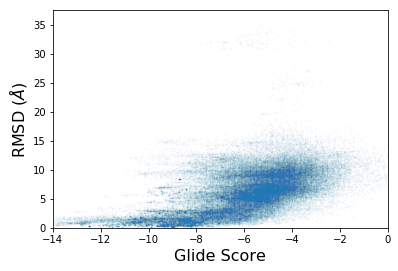

Pearson (0.56715033472356768, 0.0)
SpearmanrResult(correlation=0.59336590158073521, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


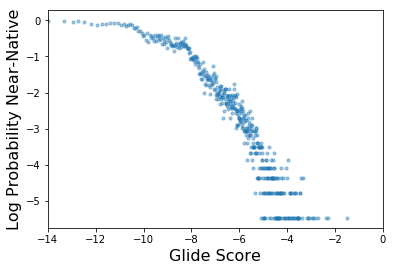

RanksumsResult(statistic=179.91340338579056, pvalue=0.0)


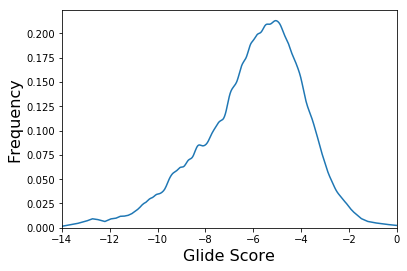

In [21]:
rmsds = np.hstack([rmsd[[0, 1]]
                   for (prot, grid), ligands in data.items()
                   for ligand, (rmsd, g, e, r) in ligands.items()
                   if ligand.split('_')[0] != grid]).T
plot(rmsds, 'Glide Score', (-14, 0))

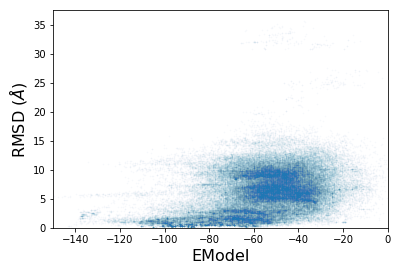

Pearson (0.36094463075325151, 0.0)
SpearmanrResult(correlation=0.34853148368691472, pvalue=0.0)


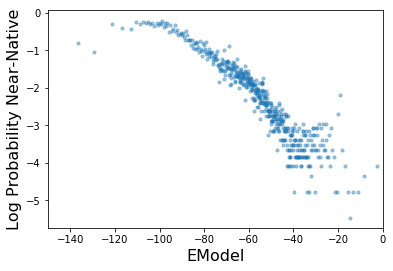

RanksumsResult(statistic=137.03203514354249, pvalue=0.0)


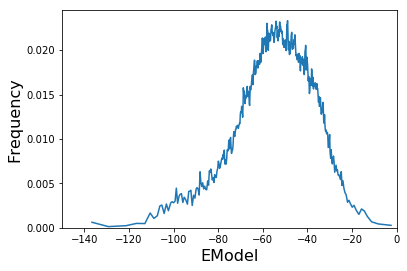

In [22]:
rmsds = np.hstack([rmsd[[0, 2]]
                   for (prot, grid), ligands in data.items()
                   for ligand, (rmsd, g, e, r) in ligands.items()
                   if ligand.split('_')[0] != grid]).T
plot(rmsds, 'EModel', (-150, 0))

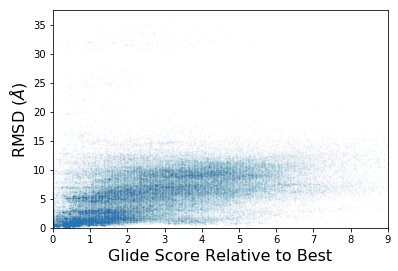

Pearson (0.44545900159737001, 0.0)
SpearmanrResult(correlation=0.50131161024667714, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


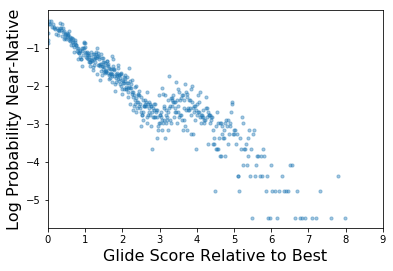

RanksumsResult(statistic=129.29916628146327, pvalue=0.0)


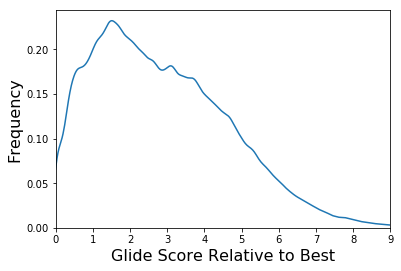

In [23]:
rmsds = []
for (prot, grid), ligands in data.items():
    for ligand, (rmsd, g, e, r) in ligands.items():
        if ligand.split('_')[0] != grid:
            rmsds += [rmsd[[0, 1]].copy()]
            rmsds[-1][1, :] -= rmsds[-1][1, 0]
rmsds = np.hstack(rmsds).T

plot(rmsds, 'Glide Score Relative to Best', (0, 9))

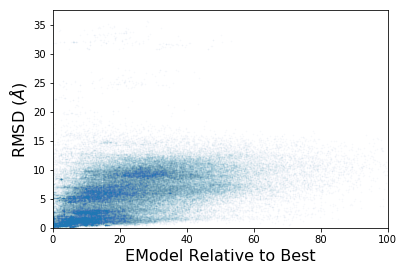

Pearson (0.42753281951542627, 0.0)
SpearmanrResult(correlation=0.48766528686155841, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


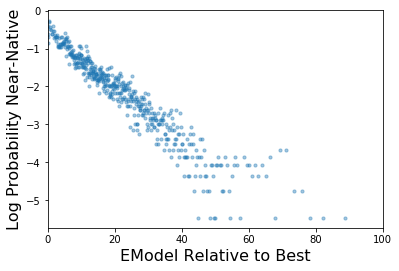

RanksumsResult(statistic=122.29799744270608, pvalue=0.0)


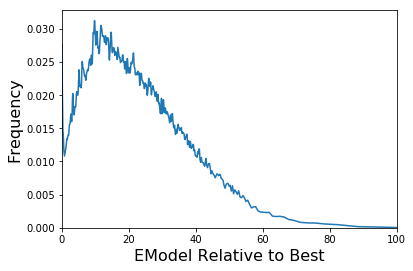

In [24]:
rmsds = []
for (prot, grid), ligands in data.items():
    for ligand, (rmsd, g, e, r) in ligands.items():
        if ligand.split('_')[0] != grid:
            rmsds += [rmsd[[0, 2]].copy()]
            rmsds[-1][1, :] -= rmsds[-1][1, :].min()
rmsds = np.hstack(rmsds).T

plot(rmsds, 'EModel Relative to Best', (0, 100))

# Direct compare EModel to GScore

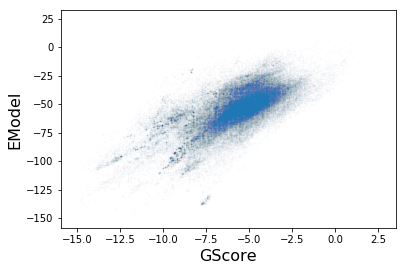

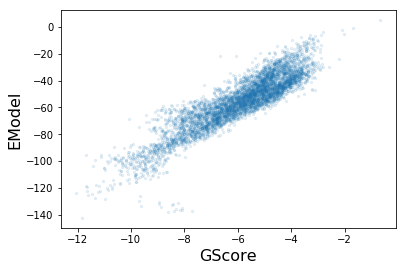

In [25]:
rmsds = [rmsds[[1, 2]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
rmsds = np.hstack(rmsds)
plt.scatter(rmsds[0], rmsds[1], s = 1, alpha = 0.01)
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.show()

quants = 5000
scores = np.vstack(sorted(rmsds.T, key = lambda x: x[1]))
bin_size = scores.shape[0] / quants
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 0].mean()]
    y += [scores[i:i+bin_size, 1].mean()]
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.scatter(x, y, s = 5, alpha = 0.1)
plt.show()

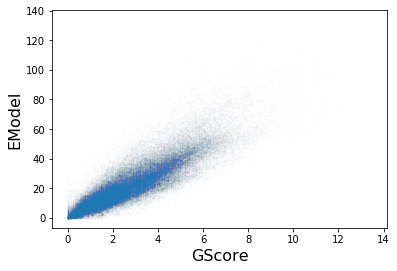

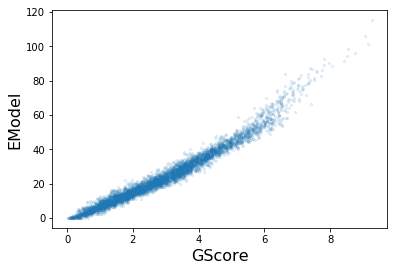

In [26]:
rmsds = [rmsds[[1, 2]] - rmsds[[1, 2]].min(axis = 1).reshape(2, 1)
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
rmsds = np.hstack(rmsds)
plt.scatter(rmsds[0], rmsds[1], s = 1, alpha = 0.01)
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.show()

quants = 5000
scores = np.vstack(sorted(rmsds.T, key = lambda x: x[1]))
bin_size = scores.shape[0] / quants
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 0].mean()]
    y += [scores[i:i+bin_size, 1].mean()]
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.scatter(x, y, s = 5, alpha = 0.1)
plt.show()